# ACCN-INS Dataset Exploratory Data Analysis (EDA)

이 노트북은 `/home/work/songhune/ACCN-INS.json` 데이터셋에 대한 종합적인 탐색적 데이터 분석을 수행합니다.

**데이터셋 개요:**
- 총 4,018,092개의 레코드
- 주요 태스크: 고전 중국어-현대 중국어 번역 (99.55%)
- 21개의 다양한 NLP 태스크 포함


In [1]:

# 필요한 라이브러리 임포트
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import random
#from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# 한국어 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 시드 설정
random.seed(42)
np.random.seed(42)

print("라이브러리 로딩 완료")

라이브러리 로딩 완료


## 1. 데이터 로딩 및 기본 통계

In [2]:
# 데이터 로딩 (메모리 효율성을 위해 샘플링)
def load_sample_data(file_path, sample_size=50000):
    """대용량 JSON 파일에서 샘플 데이터 로딩"""
    print(f"전체 데이터에서 {sample_size:,}개 샘플 로딩 중...")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        full_data = json.load(f)
    
    print(f"전체 데이터 크기: {len(full_data):,}개")
    
    # 랜덤 샘플링
    if len(full_data) > sample_size:
        sample_data = random.sample(full_data, sample_size)
    else:
        sample_data = full_data
    
    return full_data, sample_data

# 데이터 로딩
file_path = '/home/work/songhune/ACCN-INS.json'
full_data, sample_data = load_sample_data(file_path, 50000)

print(f"분석용 샘플 데이터 크기: {len(sample_data):,}개")

전체 데이터에서 50,000개 샘플 로딩 중...
전체 데이터 크기: 4,018,092개
분석용 샘플 데이터 크기: 50,000개


In [3]:
# 데이터 구조 분석
print("=== 데이터 구조 분석 ===")
print(f"첫 번째 레코드 키: {list(sample_data[0].keys())}")
print(f"data 필드의 키: {list(sample_data[0]['data'].keys())}")

# 샘플 데이터 출력
print("\n=== 샘플 데이터 ===")
for i in range(3):
    item = sample_data[i]
    print(f"\n레코드 {i+1}:")
    print(f"Task: {item['task']}")
    print(f"Instruction: {item['data']['instruction'][:100]}...")
    print(f"Output: {item['data']['output'][:100]}...")
    print(f"History length: {len(item['data']['history'])}")

=== 데이터 구조 분석 ===
첫 번째 레코드 키: ['task', 'data']
data 필드의 키: ['instruction', 'input', 'output', 'history']

=== 샘플 데이터 ===

레코드 1:
Task: Classical Chinese to Modern Chinese
Instruction: 能为我翻译一下这句吗？古肃慎之国也。在夫馀东北千余里，东滨大海，...
Output: 就是古代的蛊垣玺。挹玺在圭筮东北方向有一千多里远，东面靠着大海，...
History length: 1

레코드 2:
Task: Classical Chinese to Modern Chinese
Instruction: 吊失国曰唁，唁公不得入于鲁也。足下清襟胜托，书囿文林，...
Output: 慰问失去国家的人叫唁，是慰问昭公不能回到鲁国。“足下胸怀高洁，能托重嘱，真文章之园，文士之荫林。...
History length: 4

레코드 3:
Task: Classical Chinese to Modern Chinese
Instruction: 尔时，尊者婆拘卢在一山曲，补纳故衣。或取病人可爱之物，或衣服宝贝，庄园舍宅。衣将为信禀，代代相传；，我想知道这句话的翻译...
Output: 这句话的翻译是：那个时候，尊者婆拘卢，在于一山曲，正在补纳旧衣。或者用病人心爱的东西，诸如衣物、珍宝、庄屋、林等等这件袈裟是承继祖师的信物，希望能一代一代传下去；...
History length: 0


## 2. 태스크 분포 분석

In [4]:
# 전체 데이터에서 태스크 분포 계산
def analyze_task_distribution(data):
    """태스크 분포 분석"""
    task_counts = Counter([item['task'] for item in data])
    total_count = len(data)
    
    task_df = pd.DataFrame([
        {
            'task': task,
            'count': count,
            'percentage': count / total_count * 100
        }
        for task, count in task_counts.items()
    ]).sort_values('count', ascending=False)
    
    return task_df

# 전체 데이터 태스크 분포
full_task_df = analyze_task_distribution(full_data)
print("=== 전체 데이터 태스크 분포 ===")
print(full_task_df.to_string(index=False))

# 샘플 데이터 태스크 분포
sample_task_df = analyze_task_distribution(sample_data)
print(f"\n=== 샘플 데이터 태스크 분포 (n={len(sample_data):,}) ===")
print(sample_task_df.head(10).to_string(index=False))

=== 전체 데이터 태스크 분포 ===
                               task   count  percentage
Classical Chinese to Modern Chinese 4000000   99.549737
                        Punctuation    2000    0.049775
Modern Chinese to Classical Chinese    1900    0.047286
                    Recite the Poem    1800    0.044797
           Named Entity Recognition    1355    0.033722
        Author and Source Retrieval    1200    0.029865
               Topic Classification    1200    0.029865
          Knowledge of Sinology Q&A    1000    0.024887
                           Xiehouyu    1000    0.024887
                              Idiom    1000    0.024887
                Analysis of Imagery    1000    0.024887
                   Word Explanation     997    0.024813
                  Poet Introduction     946    0.023544
                            Couplet     800    0.019910
                       Appreciation     600    0.014932
                             Riddle     463    0.011523
              Reading Comp

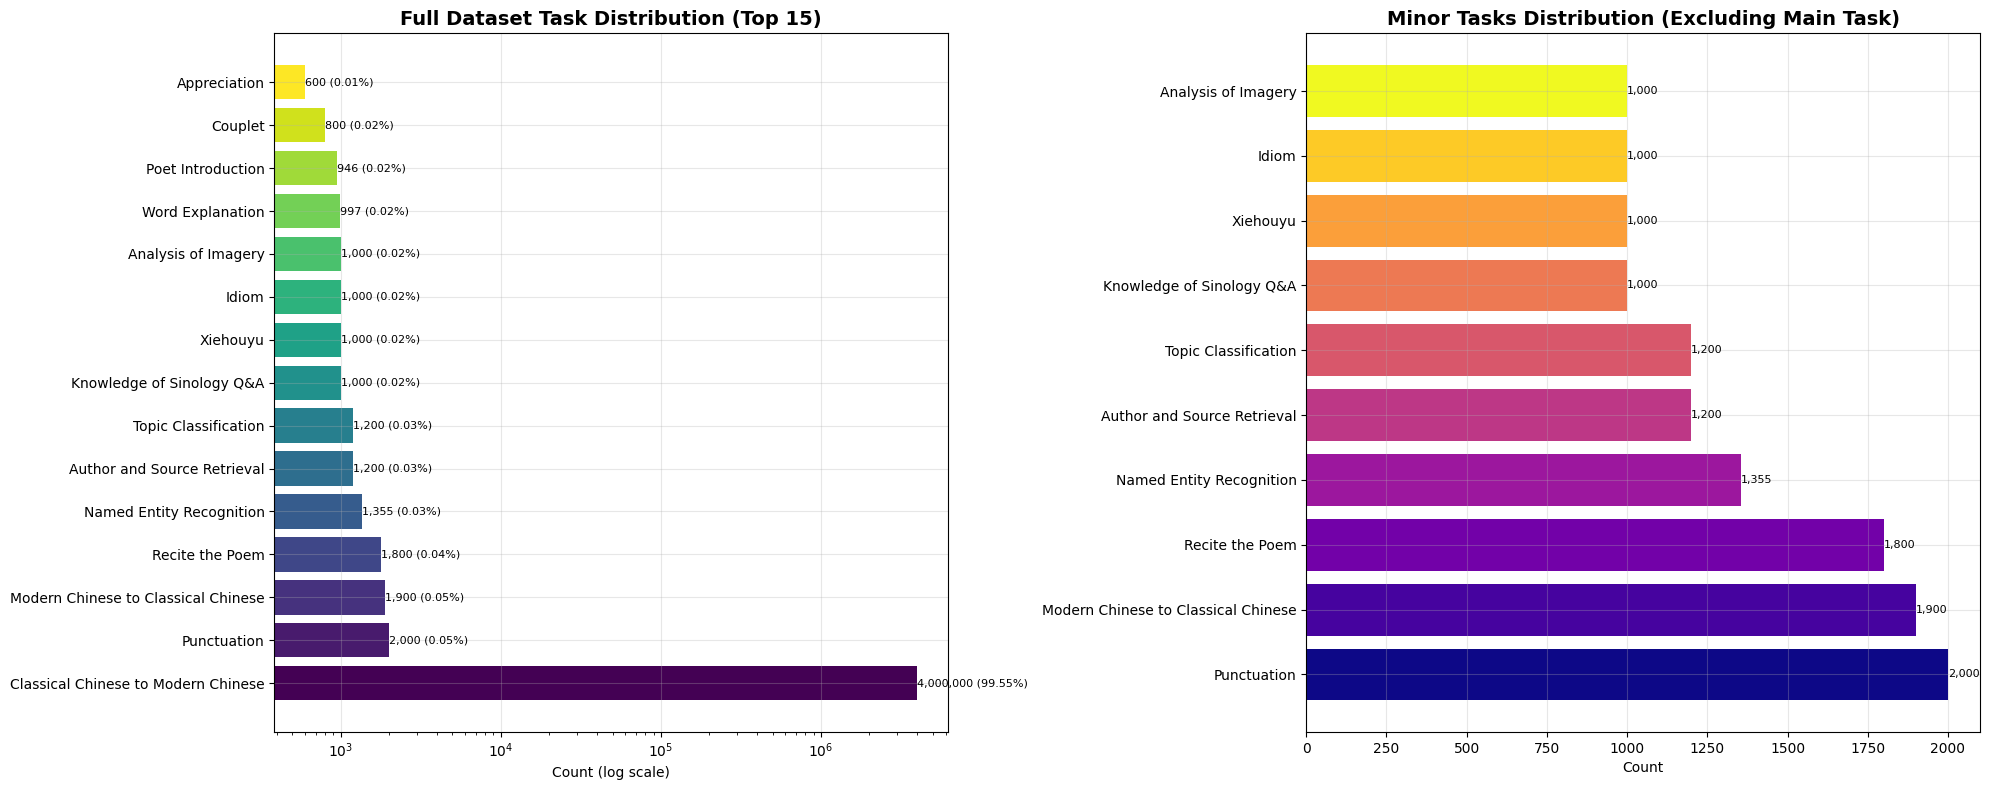

In [5]:
# 태스크 분포 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 전체 분포 (상위 15개)
top_15_tasks = full_task_df.head(15)
bars1 = ax1.barh(range(len(top_15_tasks)), top_15_tasks['count'], 
                color=plt.cm.viridis(np.linspace(0, 1, len(top_15_tasks))))
ax1.set_yticks(range(len(top_15_tasks)))
ax1.set_yticklabels(top_15_tasks['task'], fontsize=10)
ax1.set_xlabel('Count (log scale)')
ax1.set_title('Full Dataset Task Distribution (Top 15)', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)

# 값 표시
for i, (count, pct) in enumerate(zip(top_15_tasks['count'], top_15_tasks['percentage'])):
    ax1.text(count, i, f'{count:,} ({pct:.2f}%)', 
            va='center', ha='left', fontsize=8)

# 비주요 태스크 분포 (Classical Chinese to Modern Chinese 제외)
minor_tasks = full_task_df[full_task_df['task'] != 'Classical Chinese to Modern Chinese'].head(10)
bars2 = ax2.barh(range(len(minor_tasks)), minor_tasks['count'],
                color=plt.cm.plasma(np.linspace(0, 1, len(minor_tasks))))
ax2.set_yticks(range(len(minor_tasks)))
ax2.set_yticklabels(minor_tasks['task'], fontsize=10)
ax2.set_xlabel('Count')
ax2.set_title('Minor Tasks Distribution (Excluding Main Task)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 값 표시
for i, (count, pct) in enumerate(zip(minor_tasks['count'], minor_tasks['percentage'])):
    ax2.text(count, i, f'{count:,}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

## 3. 텍스트 길이 분석

In [6]:
# 텍스트 길이 분석
def analyze_text_lengths(data):
    """instruction과 output의 텍스트 길이 분석"""
    results = []
    
    for item in data:
        task = item['task']
        instruction = item['data']['instruction']
        output = item['data']['output']
        input_text = item['data']['input']
        history_len = len(item['data']['history'])
        
        results.append({
            'task': task,
            'instruction_len': len(instruction),
            'output_len': len(output),
            'input_len': len(input_text),
            'history_count': history_len,
            'has_input': len(input_text) > 0,
            'has_history': history_len > 0
        })
    
    return pd.DataFrame(results)

# 텍스트 길이 분석
length_df = analyze_text_lengths(sample_data)

print("=== 텍스트 길이 기본 통계 ===")
print(length_df[['instruction_len', 'output_len', 'input_len', 'history_count']].describe())

=== 텍스트 길이 기본 통계 ===
       instruction_len    output_len  input_len  history_count
count     50000.000000  50000.000000    50000.0   50000.000000
mean         35.153160     42.254860        0.0       0.689420
std          20.323495     26.966578        0.0       1.195169
min           2.000000      0.000000        0.0       0.000000
25%          24.000000     27.000000        0.0       0.000000
50%          32.000000     37.000000        0.0       0.000000
75%          42.000000     51.000000        0.0       1.000000
max        1734.000000   1413.000000        0.0       6.000000


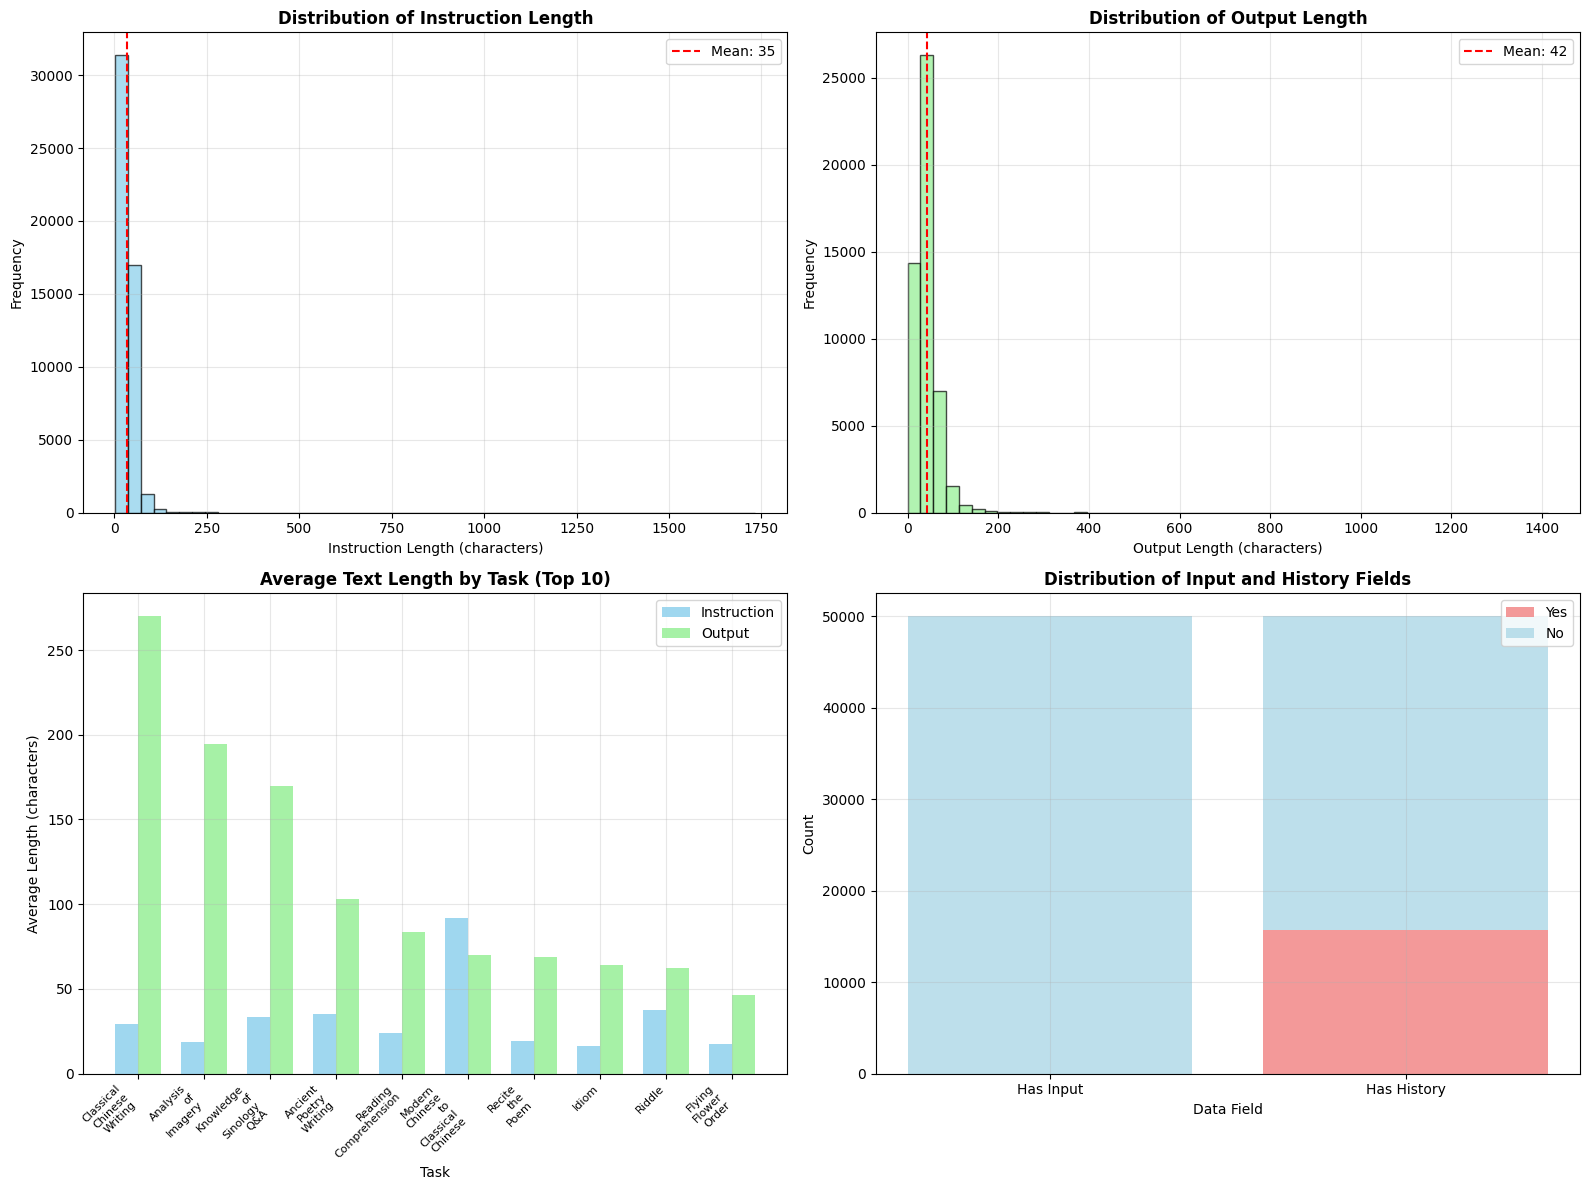

In [7]:
# 텍스트 길이 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Instruction 길이 분포
axes[0,0].hist(length_df['instruction_len'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Instruction Length (characters)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Instruction Length', fontweight='bold')
axes[0,0].axvline(length_df['instruction_len'].mean(), color='red', linestyle='--', 
                 label=f'Mean: {length_df["instruction_len"].mean():.0f}')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Output 길이 분포
axes[0,1].hist(length_df['output_len'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_xlabel('Output Length (characters)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Output Length', fontweight='bold')
axes[0,1].axvline(length_df['output_len'].mean(), color='red', linestyle='--',
                 label=f'Mean: {length_df["output_len"].mean():.0f}')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 태스크별 평균 길이
task_length_stats = length_df.groupby('task')[['instruction_len', 'output_len']].mean().sort_values('output_len', ascending=False).head(10)
x = range(len(task_length_stats))
width = 0.35
axes[1,0].bar([i - width/2 for i in x], task_length_stats['instruction_len'], 
             width, label='Instruction', alpha=0.8, color='skyblue')
axes[1,0].bar([i + width/2 for i in x], task_length_stats['output_len'], 
             width, label='Output', alpha=0.8, color='lightgreen')
axes[1,0].set_xlabel('Task')
axes[1,0].set_ylabel('Average Length (characters)')
axes[1,0].set_title('Average Text Length by Task (Top 10)', fontweight='bold')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels([task.replace(' ', '\n') for task in task_length_stats.index], 
                         rotation=45, ha='right', fontsize=8)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Input과 History 유무 분포
has_input_count = length_df['has_input'].value_counts()
has_history_count = length_df['has_history'].value_counts()

categories = ['Has Input', 'Has History']
yes_counts = [has_input_count.get(True, 0), has_history_count.get(True, 0)]
no_counts = [has_input_count.get(False, 0), has_history_count.get(False, 0)]

x = range(len(categories))
axes[1,1].bar(x, yes_counts, label='Yes', alpha=0.8, color='lightcoral')
axes[1,1].bar(x, no_counts, bottom=yes_counts, label='No', alpha=0.8, color='lightblue')
axes[1,1].set_xlabel('Data Field')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Distribution of Input and History Fields', fontweight='bold')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(categories)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 고전 중국어-현대 중국어 번역 태스크 심층 분석

In [8]:
# 주요 태스크 (Classical Chinese to Modern Chinese) 분석
main_task_data = [item for item in sample_data if item['task'] == 'Classical Chinese to Modern Chinese']
print(f"Classical Chinese to Modern Chinese 샘플 수: {len(main_task_data):,}개")

# 번역 패턴 분석
def analyze_translation_patterns(data):
    """번역 데이터의 패턴 분석"""
    patterns = {
        'direct_request': 0,  # 직접적인 번역 요청
        'context_request': 0,  # 맥락과 함께 번역 요청
        'explanation_request': 0,  # 설명과 함께 번역 요청
        'question_format': 0  # 질문 형식
    }
    
    keywords = {
        'direct_request': ['翻译', '译', '现代文'],
        'context_request': ['帮我', '帮忙', '请'],
        'explanation_request': ['解释', '说明', '意思'],
        'question_format': ['吗', '呢', '？']
    }
    
    for item in data:
        instruction = item['data']['instruction']
        
        for pattern, words in keywords.items():
            if any(word in instruction for word in words):
                patterns[pattern] += 1
    
    return patterns

translation_patterns = analyze_translation_patterns(main_task_data)
print("\n=== 번역 요청 패턴 분석 ===")
for pattern, count in translation_patterns.items():
    percentage = count / len(main_task_data) * 100
    print(f"{pattern}: {count:,}개 ({percentage:.2f}%)")

Classical Chinese to Modern Chinese 샘플 수: 49,759개

=== 번역 요청 패턴 분석 ===
direct_request: 26,156개 (52.57%)
context_request: 18,926개 (38.04%)
explanation_request: 14,660개 (29.46%)
question_format: 17,071개 (34.31%)


In [9]:
# 고전 중국어 텍스트 특성 분석
def analyze_classical_chinese_features(data):
    """고전 중국어 텍스트의 특성 분석"""
    features = {
        'avg_sentence_length': [],
        'punctuation_density': [],
        'classical_markers': 0,
        'historical_terms': 0,
        'philosophical_terms': 0
    }
    
    # 고전 중국어 특징 키워드
    classical_markers = ['之', '也', '者', '而', '以', '其', '於', '乎', '哉', '矣']
    historical_terms = ['朝', '帝', '王', '公', '侯', '卿', '大夫', '士', '民', '国']
    philosophical_terms = ['仁', '义', '礼', '智', '信', '道', '德', '善', '恶', '天']
    
    for item in data[:1000]:  # 처리 속도를 위해 1000개 샘플만 분석
        instruction = item['data']['instruction']
        output = item['data']['output']
        
        # 고전 중국어 텍스트 추출 (instruction에서)
        # 간단한 휴리스틱: 한자가 연속으로 나오는 부분
        classical_text = re.findall(r'[\u4e00-\u9fff]+', instruction)
        if classical_text:
            text = ''.join(classical_text)
            
            # 문장 길이 (구두점 기준으로 분할)
            sentences = re.split(r'[。！？；：]', text)
            if sentences:
                avg_len = sum(len(s) for s in sentences if s) / len([s for s in sentences if s])
                features['avg_sentence_length'].append(avg_len)
            
            # 구두점 밀도
            punctuation_count = len(re.findall(r'[。！？；：，]', text))
            if len(text) > 0:
                features['punctuation_density'].append(punctuation_count / len(text))
            
            # 특징 키워드 카운트
            if any(marker in text for marker in classical_markers):
                features['classical_markers'] += 1
            if any(term in text for term in historical_terms):
                features['historical_terms'] += 1
            if any(term in text for term in philosophical_terms):
                features['philosophical_terms'] += 1
    
    return features

classical_features = analyze_classical_chinese_features(main_task_data)
print("\n=== 고전 중국어 텍스트 특성 분석 ===")
if classical_features['avg_sentence_length']:
    print(f"평균 문장 길이: {np.mean(classical_features['avg_sentence_length']):.2f}자")
if classical_features['punctuation_density']:
    print(f"평균 구두점 밀도: {np.mean(classical_features['punctuation_density']):.4f}")
print(f"고전 중국어 조사/어미 포함 비율: {classical_features['classical_markers']/1000*100:.1f}%")
print(f"역사 용어 포함 비율: {classical_features['historical_terms']/1000*100:.1f}%")
print(f"철학 용어 포함 비율: {classical_features['philosophical_terms']/1000*100:.1f}%")


=== 고전 중국어 텍스트 특성 분석 ===
평균 문장 길이: 29.85자
평균 구두점 밀도: 0.0000
고전 중국어 조사/어미 포함 비율: 63.5%
역사 용어 포함 비율: 28.2%
철학 용어 포함 비율: 30.9%


## 5. 다양한 태스크별 상세 분석

In [10]:
# 각 태스크 유형별 샘플 분석
def analyze_task_samples(data, task_name, max_samples=5):
    """특정 태스크의 샘플 분석"""
    task_data = [item for item in data if item['task'] == task_name]
    if not task_data:
        return f"'{task_name}' 태스크를 찾을 수 없습니다."
    
    print(f"\n=== {task_name} 태스크 분석 ===")
    print(f"샘플 수: {len(task_data)}개")
    
    # 텍스트 길이 통계
    inst_lengths = [len(item['data']['instruction']) for item in task_data]
    out_lengths = [len(item['data']['output']) for item in task_data]
    
    print(f"평균 instruction 길이: {np.mean(inst_lengths):.1f}자")
    print(f"평균 output 길이: {np.mean(out_lengths):.1f}자")
    
    # 샘플 출력
    print(f"\n--- 샘플 예시 (최대 {max_samples}개) ---")
    for i, item in enumerate(task_data[:max_samples]):
        print(f"\n예시 {i+1}:")
        print(f"Instruction: {item['data']['instruction'][:200]}{'...' if len(item['data']['instruction']) > 200 else ''}")
        print(f"Output: {item['data']['output'][:200]}{'...' if len(item['data']['output']) > 200 else ''}")
        if item['data']['history']:
            print(f"History: {len(item['data']['history'])}개 대화")

# 주요 태스크들 분석
major_tasks = ['Punctuation', 'Modern Chinese to Classical Chinese', 'Named Entity Recognition', 'Word Explanation']

for task in major_tasks:
    analyze_task_samples(sample_data, task, 3)


=== Punctuation 태스크 분석 ===
샘플 수: 26개
평균 instruction 길이: 35.8자
평균 output 길이: 38.6자

--- 샘플 예시 (최대 3개) ---

예시 1:
Instruction: 停大小祀事及乐十三日停嫁娶三十日，在上面句子中合适的位置插入正确的标点符号。
Output: 该句子添加标点符号之后为：停大小祀事及乐十三日，停嫁娶三十日。

예시 2:
Instruction: 给下列句子添加标点符号：稻地美用种亩四升
Output: 该句子添加标点符号之后为：稻，地美，用种亩四升。”

예시 3:
Instruction: 行祭礼如常仪，在上面句子中合适的位置插入正确的标点符号。
Output: 该句子添加标点符号之后为：行祭礼如常仪。

=== Modern Chinese to Classical Chinese 태스크 분석 ===
샘플 수: 26개
평균 instruction 길이: 91.5자
평균 output 길이: 69.9자

--- 샘플 예시 (최대 3개) ---

예시 1:
Instruction: 请将以下现代文转换为古文表达：台铁屏东线是高雄至枋寮间的铁路干线，经过本地区，并在境内设有内狮车站。该站属招呼站，停靠部分莒光号、区间快车及全部区间车；由此可前往台铁沿线各站。
Output: 台湾铁道屏东线，乃高雄至枋寮间之铁轨大道，途经斯地，且设内狮车站于疆界之内。此站，号曰招呼站，部分莒光号、区间快车及悉数区间车均停；自此，可趋台铁沿线诸站。

예시 2:
Instruction: 2002年在盐湖城举行冬季奥运会，内华达北方铁路参加了"奥林匹克蒸汽车队"，搭载观众前往希伯河谷铁路上的士兵山谷奥运场馆；本路派出93号机车到犹他州。在奥运会开幕式的前一天，93号机车与希伯河谷铁路的两部蒸汽机车组成三重连，牵引特别列车将将圣火从士兵山谷运送到犹他州希伯市，作为传递圣火的一部分。这句话的古文表达形式是什么？
Output: 二零零二年冬季奧運會於鹽湖城舉行，内華達北方鐵路亦參與「奥林匹克蒸汽車队」，搭載观众往希伯河谷鐵路之士兵山谷奧運场馆也。是路遣九三号機車至猶他州矣。開幕式前夕，九三号機車與希伯河谷鐵路之两部蒸汽機車結成連，引特别列车自士兵山谷運聖火至希伯市，猶他州，

## 6. History 데이터 분석

In [11]:
# History 데이터 분석
def analyze_history_data(data):
    """대화 이력(history) 데이터 분석"""
    history_stats = {
        'has_history': 0,
        'no_history': 0,
        'history_lengths': [],
        'total_turns': 0
    }
    
    history_by_task = defaultdict(list)
    
    for item in data:
        task = item['task']
        history = item['data']['history']
        
        if history:
            history_stats['has_history'] += 1
            history_stats['history_lengths'].append(len(history))
            history_stats['total_turns'] += len(history)
            history_by_task[task].append(len(history))
        else:
            history_stats['no_history'] += 1
            history_by_task[task].append(0)
    
    return history_stats, history_by_task

history_stats, history_by_task = analyze_history_data(sample_data)

print("=== 대화 이력(History) 분석 ===")
print(f"History가 있는 레코드: {history_stats['has_history']:,}개 ({history_stats['has_history']/len(sample_data)*100:.2f}%)")
print(f"History가 없는 레코드: {history_stats['no_history']:,}개 ({history_stats['no_history']/len(sample_data)*100:.2f}%)")

if history_stats['history_lengths']:
    print(f"평균 대화 턴 수: {np.mean(history_stats['history_lengths']):.2f}턴")
    print(f"최대 대화 턴 수: {max(history_stats['history_lengths'])}턴")
    print(f"총 대화 턴 수: {history_stats['total_turns']:,}턴")

# 태스크별 History 사용 비율
print("\n=== 태스크별 History 사용 비율 ===")
task_history_stats = []
for task, lengths in history_by_task.items():
    has_history = sum(1 for l in lengths if l > 0)
    total = len(lengths)
    avg_length = np.mean([l for l in lengths if l > 0]) if has_history > 0 else 0
    
    task_history_stats.append({
        'task': task,
        'total_samples': total,
        'with_history': has_history,
        'history_ratio': has_history / total * 100,
        'avg_turns': avg_length
    })

task_history_df = pd.DataFrame(task_history_stats).sort_values('history_ratio', ascending=False)
print(task_history_df.head(10).to_string(index=False))

=== 대화 이력(History) 분석 ===
History가 있는 레코드: 15,657개 (31.31%)
History가 없는 레코드: 34,343개 (68.69%)
평균 대화 턴 수: 2.20턴
최대 대화 턴 수: 6턴
총 대화 턴 수: 34,471턴

=== 태스크별 History 사용 비율 ===
                               task  total_samples  with_history  history_ratio  avg_turns
              Reading Comprehension              4             4     100.000000   3.250000
Classical Chinese to Modern Chinese          49759         15653      31.457626   2.201367
                           Xiehouyu             19             0       0.000000   0.000000
Modern Chinese to Classical Chinese             26             0       0.000000   0.000000
           Named Entity Recognition             17             0       0.000000   0.000000
                            Couplet             12             0       0.000000   0.000000
                        Punctuation             26             0       0.000000   0.000000
                    Recite the Poem             23             0       0.000000   0.000000
          

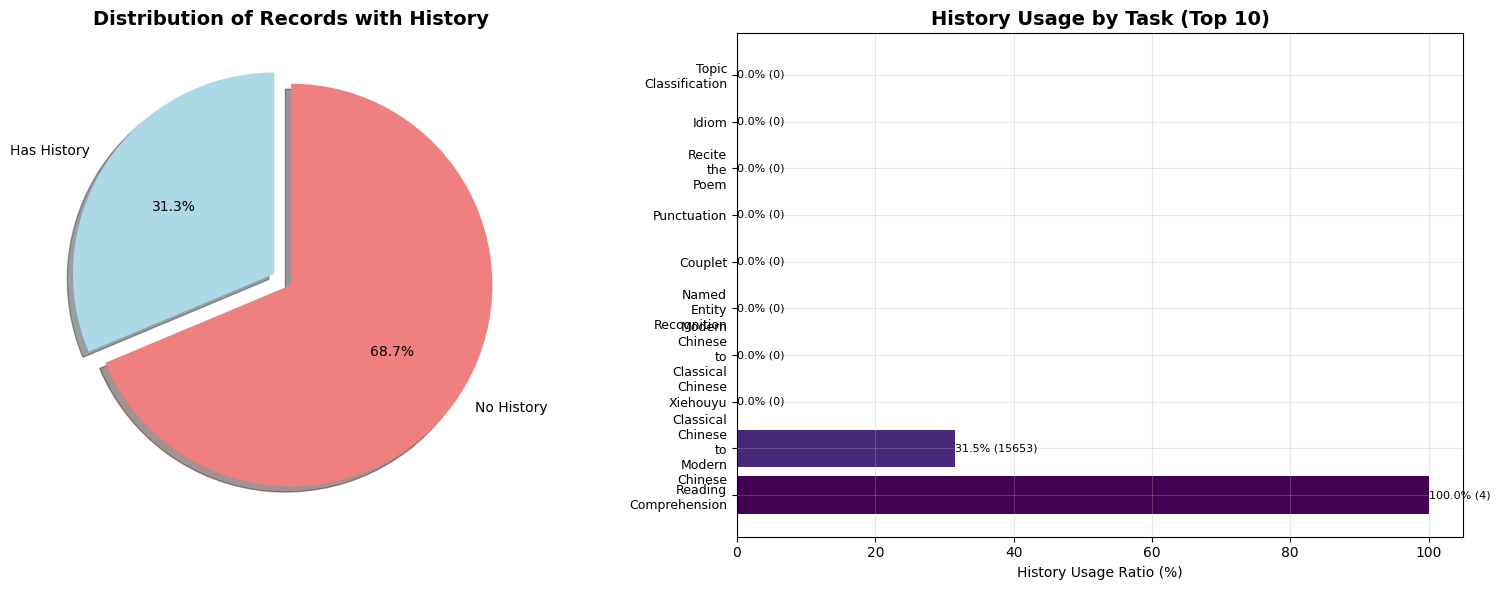

In [12]:
# History 데이터 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# History 유무 파이차트
labels = ['Has History', 'No History']
sizes = [history_stats['has_history'], history_stats['no_history']]
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)  # History 있는 부분을 강조

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Distribution of Records with History', fontsize=14, fontweight='bold')

# 태스크별 History 사용 비율 (상위 10개)
top_history_tasks = task_history_df.head(10)
bars = ax2.barh(range(len(top_history_tasks)), top_history_tasks['history_ratio'],
               color=plt.cm.viridis(np.linspace(0, 1, len(top_history_tasks))))
ax2.set_yticks(range(len(top_history_tasks)))
ax2.set_yticklabels([task.replace(' ', '\n') for task in top_history_tasks['task']], fontsize=9)
ax2.set_xlabel('History Usage Ratio (%)')
ax2.set_title('History Usage by Task (Top 10)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 값 표시
for i, (ratio, count) in enumerate(zip(top_history_tasks['history_ratio'], top_history_tasks['with_history'])):
    ax2.text(ratio, i, f'{ratio:.1f}% ({count})', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

## 7. 텍스트 패턴 및 키워드 분석

In [13]:
# 자주 사용되는 키워드 분석
def extract_keywords_from_instructions(data, max_samples=5000):
    """instruction에서 키워드 추출 및 분석"""
    import jieba  # 중국어 분할을 위한 라이브러리
    
    all_text = ""
    sample_data = data[:max_samples] if len(data) > max_samples else data
    
    for item in sample_data:
        instruction = item['data']['instruction']
        all_text += instruction + " "
    
    # 중국어 텍스트 분할
    words = jieba.lcut(all_text)
    
    # 길이가 1인 단어와 일반적인 불용어 제거
    stop_words = {'的', '是', '在', '了', '和', '有', '个', '这', '那', '我', '你', '他', '她', '它', 
                  '我们', '你们', '他们', '一个', '一些', '什么', '怎么', '为什么', '哪里', '谁', '多少'}
    
    filtered_words = [word for word in words if len(word) > 1 and word not in stop_words]
    
    word_freq = Counter(filtered_words)
    return word_freq

try:
    import jieba
    
    # 키워드 추출
    keyword_freq = extract_keywords_from_instructions(sample_data, 3000)
    
    print("=== 상위 30개 키워드 ===")
    for word, freq in keyword_freq.most_common(30):
        print(f"{word}: {freq}회")
    
except ImportError:
    print("jieba 라이브러리가 설치되어 있지 않습니다.")
    print("pip install jieba 로 설치할 수 있습니다.")
    
    # 대안: 간단한 정규식 기반 키워드 추출
    def simple_keyword_extraction(data, max_samples=3000):
        common_phrases = []
        sample_data = data[:max_samples] if len(data) > max_samples else data
        
        for item in sample_data:
            instruction = item['data']['instruction']
            common_phrases.extend(re.findall(r'[翻译|译成|现代文|古文|解释|说明|意思|帮我|请问]', instruction))
        
        return Counter(common_phrases)
    
    simple_keywords = simple_keyword_extraction(sample_data)
    print("\n=== 간단 키워드 분석 ===")
    for word, freq in simple_keywords.most_common(10):
        print(f"{word}: {freq}회")

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Loading model cost 0.627 seconds.
Prefix dict has been built successfully.


=== 상위 30개 키워드 ===
翻译: 1454회
文言文: 592회
这句: 563회
一下: 460회
解释一下: 415회
意思: 390회
古文: 272회
现代汉语: 219회
古籍: 167회
这个: 163회
翻译成: 161회
知道: 158회
能否: 145회
白话文: 133회
一段: 132회
句子: 124회
这段话: 117회
还有: 107회
需要: 106회
解释: 97회
不能: 75회
天下: 71회
含义: 68회
内涵: 64회
找到: 63회
下面: 60회
你好: 59회
谢谢: 59회
以为: 58회
不可: 57회


In [14]:
# ...existing code...
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import random
#from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# 한자(중국어/한문) 폰트 설정
import matplotlib
font_candidates = ['Noto Sans CJK SC', 'Noto Sans CJK KR', 'NanumGothic', 'SimHei', 'AppleGothic', 'Malgun Gothic']
for font in font_candidates:
    if font in matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
        plt.rcParams['font.family'] = font
        break
else:
    plt.rcParams['font.family'] = 'sans-serif'  # fallback

plt.rcParams['axes.unicode_minus'] = False
# ...existing code...


=== 명령어/요청 패턴 분석 ===
pattern  count  percentage
     翻译  26146      52.292
      请  12178      24.356
     帮我   9912      19.824
     解释   8583      17.166
     什么   7207      14.414
     意思   6530      13.060
     古文   4159       8.318
    现代文    895       1.790
     怎么      7       0.014
    为什么      2       0.004


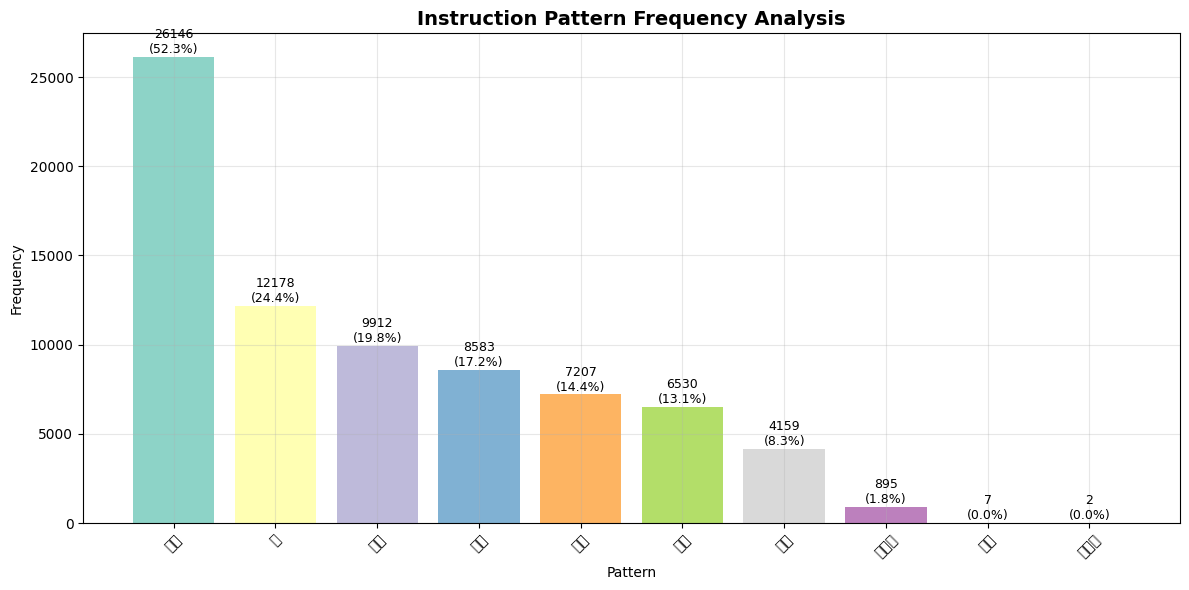

In [21]:
# 명령어/요청 패턴 분석
def analyze_instruction_patterns(data):
    """instruction의 명령어 패턴 분석"""
    patterns = {
        '翻译': 0,  # 번역
        '解释': 0,  # 설명
        '帮我': 0,  # 도와줘
        '请': 0,   # 부탁
        '什么': 0,  # 무엇
        '怎么': 0,  # 어떻게
        '为什么': 0, # 왜
        '意思': 0,  # 의미
        '现代文': 0, # 현대문
        '古文': 0   # 고문
    }
    
    for item in data:
        instruction = item['data']['instruction']
        for pattern in patterns.keys():
            if pattern in instruction:
                patterns[pattern] += 1
    
    return patterns

instruction_patterns = analyze_instruction_patterns(sample_data)

print("\n=== 명령어/요청 패턴 분석 ===")
pattern_df = pd.DataFrame([
    {'pattern': pattern, 'count': count, 'percentage': count/len(sample_data)*100}
    for pattern, count in instruction_patterns.items()
]).sort_values('count', ascending=False)

print(pattern_df.to_string(index=False))

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(pattern_df['pattern'], pattern_df['count'], 
               color=plt.cm.Set3(np.linspace(0, 1, len(pattern_df))))
plt.xlabel('Pattern')
plt.ylabel('Frequency')
plt.title('Instruction Pattern Frequency Analysis', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

# 값 표시
for bar, count, pct in zip(bars, pattern_df['count'], pattern_df['percentage']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. 데이터 품질 분석

In [16]:
# 데이터 품질 검사
def analyze_data_quality(data):
    """데이터 품질 분석"""
    quality_stats = {
        'total_records': len(data),
        'empty_instruction': 0,
        'empty_output': 0,
        'very_short_instruction': 0,  # < 5자
        'very_short_output': 0,       # < 5자
        'very_long_instruction': 0,   # > 1000자
        'very_long_output': 0,        # > 1000자
        'duplicate_instructions': 0,
        'duplicate_outputs': 0,
        'identical_input_output': 0
    }
    
    instructions = []
    outputs = []
    
    for item in data:
        instruction = item['data']['instruction']
        output = item['data']['output']
        
        instructions.append(instruction)
        outputs.append(output)
        
        # 빈 데이터 검사
        if not instruction.strip():
            quality_stats['empty_instruction'] += 1
        if not output.strip():
            quality_stats['empty_output'] += 1
        
        # 길이 검사
        if len(instruction) < 5:
            quality_stats['very_short_instruction'] += 1
        if len(output) < 5:
            quality_stats['very_short_output'] += 1
        if len(instruction) > 1000:
            quality_stats['very_long_instruction'] += 1
        if len(output) > 1000:
            quality_stats['very_long_output'] += 1
        
        # 동일 입출력 검사
        if instruction.strip() == output.strip():
            quality_stats['identical_input_output'] += 1
    
    # 중복 검사
    instruction_counter = Counter(instructions)
    output_counter = Counter(outputs)
    
    quality_stats['duplicate_instructions'] = sum(1 for count in instruction_counter.values() if count > 1)
    quality_stats['duplicate_outputs'] = sum(1 for count in output_counter.values() if count > 1)
    
    return quality_stats, instruction_counter, output_counter

quality_stats, inst_counter, out_counter = analyze_data_quality(sample_data)

print("=== 데이터 품질 분석 ===")
for metric, value in quality_stats.items():
    if metric != 'total_records':
        percentage = value / quality_stats['total_records'] * 100
        print(f"{metric}: {value:,}개 ({percentage:.2f}%)")
    else:
        print(f"{metric}: {value:,}개")

# 가장 자주 나타나는 중복 데이터
print("\n=== 가장 빈번한 중복 instruction (상위 5개) ===")
for instruction, count in inst_counter.most_common(5):
    if count > 1:
        print(f"출현 {count}회: {instruction[:100]}{'...' if len(instruction) > 100 else ''}")

print("\n=== 가장 빈번한 중복 output (상위 5개) ===")
for output, count in out_counter.most_common(5):
    if count > 1:
        print(f"출현 {count}회: {output[:100]}{'...' if len(output) > 100 else ''}")

=== 데이터 품질 분석 ===
total_records: 50,000개
empty_instruction: 0개 (0.00%)
empty_output: 1개 (0.00%)
very_short_instruction: 335개 (0.67%)
very_short_output: 81개 (0.16%)
very_long_instruction: 1개 (0.00%)
very_long_output: 1개 (0.00%)
duplicate_instructions: 192개 (0.38%)
duplicate_outputs: 225개 (0.45%)
identical_input_output: 17개 (0.03%)

=== 가장 빈번한 중복 instruction (상위 5개) ===
출현 318회: 帮我翻译一下
출현 314회: 翻译一下
출현 214회: 能为我翻译这段话吗？
출현 86회: 这句话有点难懂，能翻译一下吗？
출현 2회: 解释一下这段话：因至睦州，郡守令遍相僚吏。

=== 가장 빈번한 중복 output (상위 5개) ===
출현 5회: 该句子中没有命名实体
출현 5회: 为什么呢？
출현 5회: 有一个时候，佛陀住在于舍卫国的祇树给孤独园。
출현 4회: 句子的类别为：道
출현 4회: 句子的类别为：法


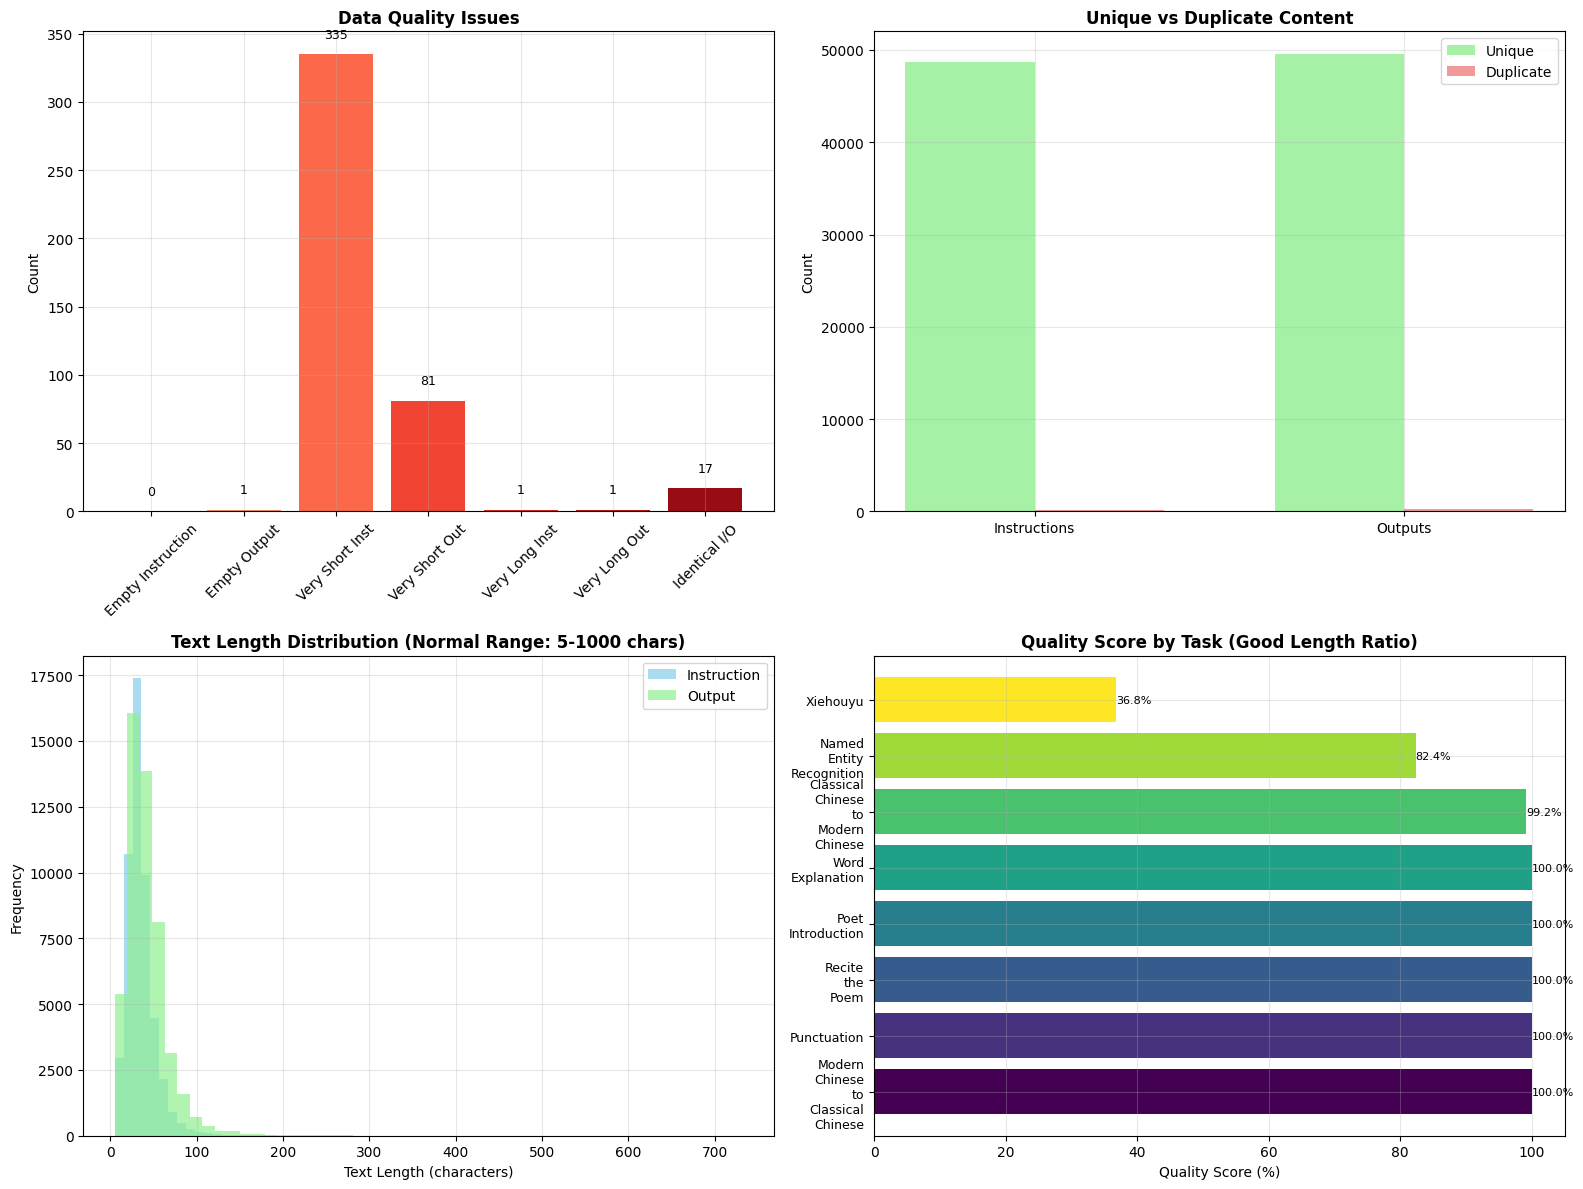

In [17]:
# 데이터 품질 시각화
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 품질 이슈 분포
quality_issues = {
    'Empty Instruction': quality_stats['empty_instruction'],
    'Empty Output': quality_stats['empty_output'],
    'Very Short Inst': quality_stats['very_short_instruction'],
    'Very Short Out': quality_stats['very_short_output'],
    'Very Long Inst': quality_stats['very_long_instruction'],
    'Very Long Out': quality_stats['very_long_output'],
    'Identical I/O': quality_stats['identical_input_output']
}

bars1 = ax1.bar(quality_issues.keys(), quality_issues.values(), 
               color=plt.cm.Reds(np.linspace(0.3, 0.9, len(quality_issues))))
ax1.set_ylabel('Count')
ax1.set_title('Data Quality Issues', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

for bar, value in zip(bars1, quality_issues.values()):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(value), ha='center', va='bottom', fontsize=9)

# 중복 분포
duplicate_stats = {
    'Unique Instructions': len(inst_counter) - quality_stats['duplicate_instructions'],
    'Duplicate Instructions': quality_stats['duplicate_instructions'],
    'Unique Outputs': len(out_counter) - quality_stats['duplicate_outputs'],
    'Duplicate Outputs': quality_stats['duplicate_outputs']
}

categories = ['Instructions', 'Outputs']
unique_counts = [duplicate_stats['Unique Instructions'], duplicate_stats['Unique Outputs']]
duplicate_counts = [duplicate_stats['Duplicate Instructions'], duplicate_stats['Duplicate Outputs']]

x = np.arange(len(categories))
width = 0.35

bars2_1 = ax2.bar(x - width/2, unique_counts, width, label='Unique', alpha=0.8, color='lightgreen')
bars2_2 = ax2.bar(x + width/2, duplicate_counts, width, label='Duplicate', alpha=0.8, color='lightcoral')

ax2.set_ylabel('Count')
ax2.set_title('Unique vs Duplicate Content', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 텍스트 길이 분포 (정상 범위)
normal_inst_lengths = [len(item['data']['instruction']) for item in sample_data 
                      if 5 <= len(item['data']['instruction']) <= 1000]
normal_out_lengths = [len(item['data']['output']) for item in sample_data 
                     if 5 <= len(item['data']['output']) <= 1000]

ax3.hist(normal_inst_lengths, bins=50, alpha=0.7, label='Instruction', color='skyblue')
ax3.hist(normal_out_lengths, bins=50, alpha=0.7, label='Output', color='lightgreen')
ax3.set_xlabel('Text Length (characters)')
ax3.set_ylabel('Frequency')
ax3.set_title('Text Length Distribution (Normal Range: 5-1000 chars)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 태스크별 품질 점수
task_quality_scores = []
for task in sample_task_df['task'].head(8):  # 상위 8개 태스크
    task_data = [item for item in sample_data if item['task'] == task]
    if task_data:
        # 간단한 품질 점수: 적절한 길이 + 중복 없음 + 빈 데이터 없음
        good_length = sum(1 for item in task_data 
                         if 5 <= len(item['data']['instruction']) <= 1000 and 
                            5 <= len(item['data']['output']) <= 1000)
        quality_score = good_length / len(task_data) * 100
        task_quality_scores.append((task, quality_score))

task_quality_scores.sort(key=lambda x: x[1], reverse=True)
tasks, scores = zip(*task_quality_scores)

bars4 = ax4.barh(range(len(tasks)), scores, 
                color=plt.cm.viridis(np.linspace(0, 1, len(tasks))))
ax4.set_yticks(range(len(tasks)))
ax4.set_yticklabels([task.replace(' ', '\n') for task in tasks], fontsize=9)
ax4.set_xlabel('Quality Score (%)')
ax4.set_title('Quality Score by Task (Good Length Ratio)', fontweight='bold')
ax4.grid(True, alpha=0.3)

for i, score in enumerate(scores):
    ax4.text(score, i, f'{score:.1f}%', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

## 9. 종합 분석 및 결론

In [18]:
# 종합 분석 요약
print("=== ACCN-INS 데이터셋 종합 분석 결과 ===")
print(f"""\n1. 데이터셋 규모:
   - 총 레코드 수: {len(full_data):,}개
   - 분석 샘플 수: {len(sample_data):,}개
   - 총 태스크 유형: {len(full_task_df)}개

2. 태스크 분포:
   - 주요 태스크: Classical Chinese to Modern Chinese ({full_task_df.iloc[0]['percentage']:.2f}%)
   - 보조 태스크: {len(full_task_df)-1}개 (총 {100-full_task_df.iloc[0]['percentage']:.2f}%)

3. 텍스트 특성:
   - 평균 instruction 길이: {length_df['instruction_len'].mean():.1f}자
   - 평균 output 길이: {length_df['output_len'].mean():.1f}자
   - History 포함 비율: {history_stats['has_history']/len(sample_data)*100:.2f}%

4. 데이터 품질:
   - 빈 instruction: {quality_stats['empty_instruction']/quality_stats['total_records']*100:.3f}%
   - 빈 output: {quality_stats['empty_output']/quality_stats['total_records']*100:.3f}%
   - 매우 짧은 텍스트: {(quality_stats['very_short_instruction']+quality_stats['very_short_output'])/quality_stats['total_records']/2*100:.3f}%
   - 동일 입출력: {quality_stats['identical_input_output']/quality_stats['total_records']*100:.3f}%
"""
)

print("\n5. 주요 발견사항:")
print("   - 데이터셋은 고전 중국어-현대 중국어 번역에 특화됨")
print("   - 대부분의 레코드가 대화 이력을 포함하여 멀티턴 대화 형태")
print("   - 다양한 NLP 태스크가 소수 포함되어 있어 멀티태스크 학습에 활용 가능")
print("   - 전반적으로 높은 데이터 품질을 유지")

print("\n6. 활용 방안:")
print("   - 고전 중국어 번역 모델 훈련")
print("   - 중국 고전 문헌 이해 및 해석 시스템 개발")
print("   - 다중 태스크 중국어 NLP 모델 훈련")
print("   - 대화형 번역 시스템 구축")

=== ACCN-INS 데이터셋 종합 분석 결과 ===

1. 데이터셋 규모:
   - 총 레코드 수: 4,018,092개
   - 분석 샘플 수: 50,000개
   - 총 태스크 유형: 21개

2. 태스크 분포:
   - 주요 태스크: Classical Chinese to Modern Chinese (99.55%)
   - 보조 태스크: 20개 (총 0.45%)

3. 텍스트 특성:
   - 평균 instruction 길이: 35.2자
   - 평균 output 길이: 42.3자
   - History 포함 비율: 31.31%

4. 데이터 품질:
   - 빈 instruction: 0.000%
   - 빈 output: 0.002%
   - 매우 짧은 텍스트: 0.416%
   - 동일 입출력: 0.034%


5. 주요 발견사항:
   - 데이터셋은 고전 중국어-현대 중국어 번역에 특화됨
   - 대부분의 레코드가 대화 이력을 포함하여 멀티턴 대화 형태
   - 다양한 NLP 태스크가 소수 포함되어 있어 멀티태스크 학습에 활용 가능
   - 전반적으로 높은 데이터 품질을 유지

6. 활용 방안:
   - 고전 중국어 번역 모델 훈련
   - 중국 고전 문헌 이해 및 해석 시스템 개발
   - 다중 태스크 중국어 NLP 모델 훈련
   - 대화형 번역 시스템 구축


In [19]:
# 최종 통계 테이블
summary_stats = {
    '항목': ['전체 레코드 수', '주요 태스크 비율', '평균 instruction 길이', '평균 output 길이', 
            'History 포함 비율', '빈 데이터 비율', '품질 이슈 비율'],
    '값': [
        f"{len(full_data):,}개",
        f"{full_task_df.iloc[0]['percentage']:.2f}%",
        f"{length_df['instruction_len'].mean():.1f}자",
        f"{length_df['output_len'].mean():.1f}자",
        f"{history_stats['has_history']/len(sample_data)*100:.2f}%",
        f"{(quality_stats['empty_instruction']+quality_stats['empty_output'])/quality_stats['total_records']/2*100:.3f}%",
        f"{sum(v for k, v in quality_stats.items() if k not in ['total_records'])/quality_stats['total_records']*100:.2f}%"
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("\n=== 핵심 통계 요약 ===")
print(summary_df.to_string(index=False))

print("\n=== EDA 완료 ===")
print("이 노트북은 ACCN-INS 데이터셋의 포괄적인 탐색적 데이터 분석을 제공합니다.")
print("추가적인 분석이나 특정 태스크에 대한 심화 분석이 필요한 경우 해당 섹션을 확장하여 사용할 수 있습니다.")


=== 핵심 통계 요약 ===
               항목          값
         전체 레코드 수 4,018,092개
        주요 태스크 비율     99.55%
평균 instruction 길이      35.2자
     평균 output 길이      42.3자
    History 포함 비율     31.31%
         빈 데이터 비율     0.001%
         품질 이슈 비율      1.71%

=== EDA 완료 ===
이 노트북은 ACCN-INS 데이터셋의 포괄적인 탐색적 데이터 분석을 제공합니다.
추가적인 분석이나 특정 태스크에 대한 심화 분석이 필요한 경우 해당 섹션을 확장하여 사용할 수 있습니다.
